In [1]:
import math as mth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score,classification_report, roc_curve,auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer,FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
from xgboost import XGBClassifier,XGBRegressor
import tensorflow as tf
import scipy
from scipy.stats import linregress
from scipy.stats import pearsonr
import statsmodels
from statsmodels.tsa.stattools import acf
from datetime import datetime, timedelta
import random
import sys
import os
from io import StringIO
import json # library to handle JSON files
from matplotlib import cm,colors
from matplotlib.colors import Normalize
from geopy.geocoders import Nominatim # convert an place into latitude and longitude values
import folium # map rendering library
from bs4 import BeautifulSoup
import camelot
import requests
from IPython import get_ipython

In [2]:
import warnings

# Customize how warnings are displayed
warnings.filterwarnings('always', module='.*')
warnings.formatwarning = lambda message, category, filename, lineno, line=None: f'{category.__name__}: {message}\n'

General Classes and Functions

In [3]:
# Class to create Plots grid

from itertools import product,cycle,combinations
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class Plotsgrid:

    """ Creates a nxn grid of plots for an input df. Shows blank for grid values exceeding number of columns of df"""


    def __init__(self,df):
        self.df=df 

    def figure_params(self,size_fac1,size_fac2):
        df=self.df
        n_data_cols=len(df.columns)
        self.n_data_cols=n_data_cols 

        n_cols=int(n_data_cols**.5)
        n_rows=0
        while n_rows*n_cols<n_data_cols:
            n_rows+=1
        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(int(size_fac1*n_data_cols),int(size_fac2*n_rows)))
        
        # Flatten the axs array for easier iteration
        if n_rows == 1 and n_cols == 1:  # Only one subplot
            self.axs = [axs]
        else:
            self.axs = axs.flatten()

    # Loop through the axes and Hist plot
    def histplots(self,bins=-1,density=False):
        # Initialize figure 
        self.figure_params(1,2)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            if bins==-1:
                if density:
                    sns.histplot(data=self.df, x=col, ax=ax,stat='density')  # Plot the histogram on the current axis
                else:
                    sns.histplot(data=self.df, x=col, ax=ax)  # Plot the histogram on the current axis
            else:
                if density:
                    sns.histplot(data=self.df, x=col, ax=ax,bins=bins,stat='density')  # Plot the histogram on the current axis
                else:
                    sns.histplot(data=self.df, x=col, ax=ax,bins=bins)  # Plot the histogram on the current axis
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Box plot
    def boxplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Initialize figure 
        self.figure_params(1,2)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(df.columns)
        for i,ax in enumerate(self.axs):
            try:
                if i==self.n_data_cols:
                    ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                    break
                col = next(cycler)  # Get the next column name
                sns.boxplot(data=df, y=col, ax=ax)  # Plot the boxplot on the current axis
            except Exception as E:
                print(E)
        plt.tight_layout()
        plt.show()

    # Loop through the axes and Line plot
    def lineplots(self):
        # Initialize figure 
        self.figure_params(5,5)
        # Create a cycler to iterate over the DataFrame columns
        cycler = cycle(self.df.columns)
        for i,ax in enumerate(self.axs):
            if i==self.n_data_cols:
                ax.set_visible(False)  # Hide any extra subplots if there are more subplots than columns
                break
            col = next(cycler)  # Get the next column name
            print(col)
            sns.lineplot(data=self.df,x=self.df.index,y=col, ax=ax)  # Plot the Line on the current axis
        plt.tight_layout()
        plt.show()

    def scatterplots(self):

        # Coerce df to numeric:
        df=self.df.apply(pd.to_numeric,errors='coerce').dropna(how='all',axis=1)
        
        # Get all numeric combinations
        col_combinations = list(combinations(df.columns, 2))
        num_combs = len(col_combinations)
        
        # Calculate grid size based on the number of combinations
        n_cols = int(np.ceil(np.sqrt(num_combs)))
        n_rows = int(np.ceil(num_combs / n_cols))

        # Create the figure and axes grid
        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(int(2*n_cols),int(2.5*n_rows)))
        
        plt.suptitle('Pairwise Scatter with higher correlations shown brighter')
        axs = axs.flatten()  # Flatten the axes array for easier iteration

        # Iterate through each combination and plot scatterplots
        for i, (col_x, col_y) in enumerate(col_combinations):
            ax = axs[i]

            df_x_y=df[[col_x,col_y]].dropna()

            x = df_x_y[col_x]
            y = df_x_y[col_y]

            # Calculate Pearson correlation and p-value
            if len(x) > 1 and len(y) > 1:  # Ensure there are enough data points
                corr, p_value = pearsonr(x, y)
                corr_array=np.array([corr]*x.shape[0])
                # Scatter plot with colored points
                sns.scatterplot(x=x, y=y, ax=ax,hue=corr_array, palette='coolwarm',hue_norm=(-1,1),legend=False)

                # Add correlation coefficient and p-value as the legend
                ax.text(0.05, 0.95, f"r = {corr:.2f}\np = {p_value:.2e}", 
                        transform=ax.transAxes, fontsize=7, verticalalignment='top',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="black"))
                
                # Set plot labels
                ax.set_xlabel(col_x)
                ax.set_ylabel(col_y)

        # Hide any extra subplots
        for j in range(i + 1, len(axs)):
            axs[j].set_visible(False)
        plt.tight_layout()
        plt.show()

In [4]:
def mape(y_true, y_pred):
    """Compute the mean absolute percentage error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def basic_eda(df):
    # Check if 'df' is a DataFrame
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df=pd.DataFrame(df)
    cols=df.columns.tolist()
    print('\nCOLUMNS LIST: ')
    print(cols)
    print('\nFIRST FEW: ')
    print(df.head(3))
    print('\nLAST FEW: ')
    print(df.tail(3))
    print('\nINFO: ')
    print(df.info())
    print('\nDESCRIPTION: ')
    print(df.describe())
    return cols

## Data Extraction

In [6]:
df_logins=pd.read_json('logins.json')
df_data=pd.read_json('ultimate_data_challenge.json')

## Part 1: Exploratory Data Analysis (EDA)

In [7]:
logins_cols=basic_eda(df_logins)


COLUMNS LIST: 
['login_time']

FIRST FEW: 
           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37

LAST FEW: 
               login_time
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23

INFO: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None

DESCRIPTION: 
                          login_time
count                          93142
mean   1970-02-26 19:09:39.779648278
min              1970-01-01 20:12:16
25%       1970-02-04 10:37:19.750000
50%       1970-03-01 06:33:05.500000
75%       1970-03-22 04:01:10.750000
max              1970-04-13 18:57:38


<li> the logins info is imported into a dataframe of one column called 'login_time' with 93142 values
<li> 'login_time' contains all non-null values of type datetime64[ns]
<li> The mean, percentiles, std and max are timestamps 
<li><b><i> Data Issue: The timestamps are not ordered chronologically </i></b>

In [8]:
# Create a dummy column called 'num'
df_logins['num']=1
# Ensure datetime format for login_time
df_logins['login_time'] = pd.to_datetime(df_logins['login_time'])  # Ensure datetime format
# Set 'login_time' as the index
df_logins.set_index('login_time', inplace=True)
# Sort by index
df_logins.sort_index(inplace=True)


<b> Time Plot of time ordered original data: </b>

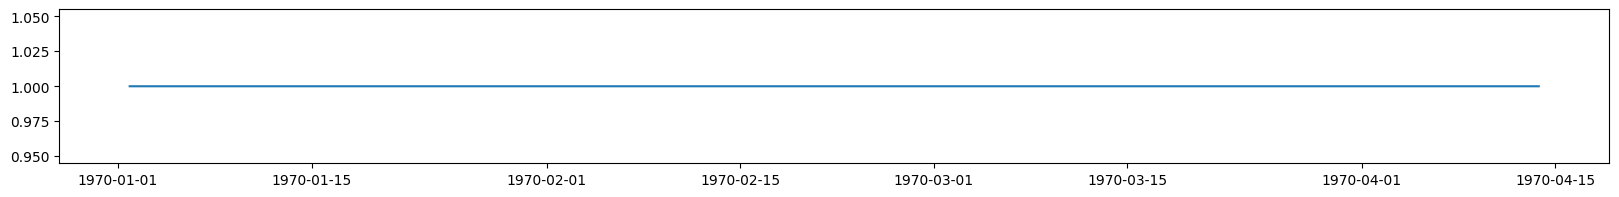

In [9]:
fig,axs=plt.subplots(figsize=(20,2))
axs.plot(df_logins)

<li> The dataframe is a timestamp collection from '1970-01-01' to '1970-04-13' so about 3.5 months

### Aggregation based on 15 minute intervals

In [10]:
# Create Aggregation
df_logins_agg=df_logins.copy()
# Resample based on 15-minute intervals and aggregate 
df_logins_agg = df_logins_agg.resample('15min').count()  

cols_logins_agg=basic_eda(df_logins_agg)



COLUMNS LIST: 
['num']

FIRST FEW: 
                     num
login_time              
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9

LAST FEW: 
                     num
login_time              
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6

INFO: 
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   num     9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB
None

DESCRIPTION: 
               num
count  9788.000000
mean      9.515938
std       8.328818
min       0.000000
25%       3.000000
50%       7.000000
75%      13.000000
max      73.000000


<li> There are 9788 entries of 15 minute intervals in the resampled data of count of logins

<b> Time Plot: </b>

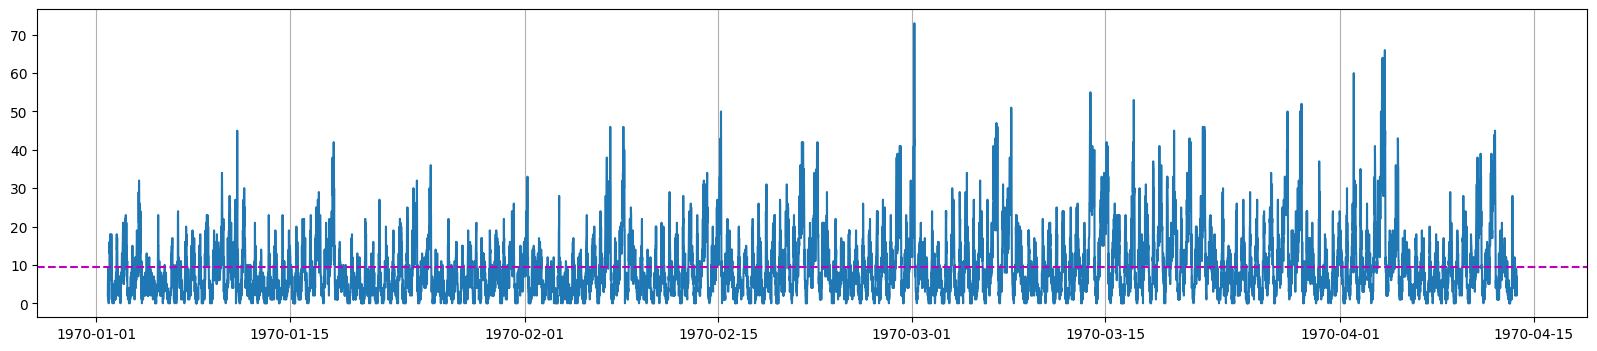

In [11]:
mean_logins=df_logins_agg.mean().values[0]
#rolling_logins=df_logins_agg.rolling(3).mean().interpolate().bfill()
plt.figure(figsize=(20,4))
plt.plot(df_logins_agg)
#plt.plot(rolling_logins,'-y')
plt.axhline(mean_logins,linestyle='--',color='m')
plt.grid(axis='x')
plt.show()

<li> There seems to be significant fluctuations in login with variation around mean
<li> Possible seasonality effect
<br>
<p> Let's look at the lagged autocorrelation to explore seasonality </p>

[ 1.          0.83065749  0.7838773  ... -0.05604951 -0.04703516
 -0.04032371]


array([ 48,  96, 151, 193, 247, 288, 329, 384, 426, 480, 522, 576, 622,
       672, 719, 768, 823, 864, 918, 960], dtype=int64)

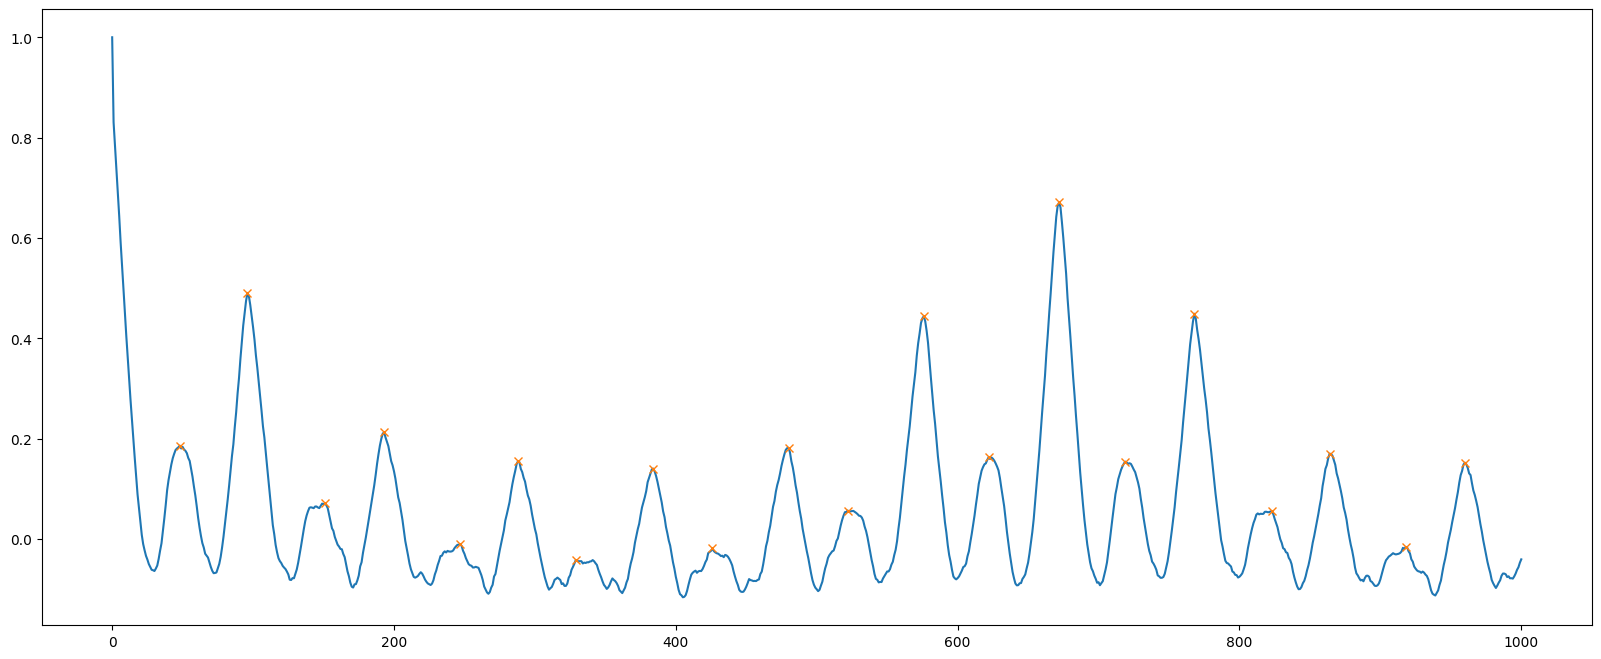

In [12]:
# Assuming 'df_logins_agg' is your time series data (as a pandas Series or DataFrame column)
# Calculate ACF values up to 1000 lags
acf_values = acf(df_logins_agg, nlags=1000)  # Adjust 'nlags' as needed

# Display the ACF values
print(acf_values)

# Determining the peaks of the ACF plots
peaks1, _ = scipy.signal.find_peaks(acf_values,prominence=.05)
plt.figure(figsize=(20,8))
plt.plot(acf_values)
plt.plot(peaks1,acf_values[peaks1],'x')
peaks1

<b> Plot a distribution of the difference of the peaks indices:

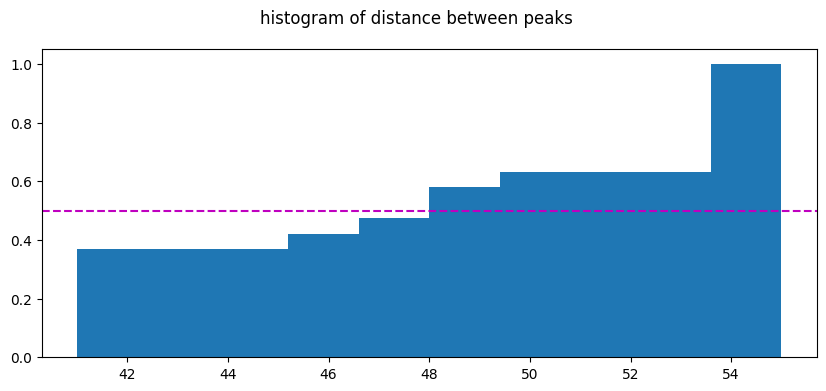

Mean Difference:  [48.]


In [13]:
fig,axs=plt.subplots(figsize=(10,4))
axs.hist(pd.DataFrame(peaks1).diff().dropna(),cumulative=True,density=True)
axs.axhline(y=.5,linestyle='--',color='m')
plt.suptitle('histogram of distance between peaks')
plt.show()
print('Mean Difference: ',pd.DataFrame(peaks1).diff().dropna().mean().values)

<li> The distance between peaks varies from roughly 41 to 55.
<li> The CDF value of .5 corresponds to roughly 48.
<br><p><i> 
<li> Hence the seasonality of logins can be considered to be 48 
<li> <b>Since each subsequent value is the login counts of 15 minutes, the actual seasonality = 15*48 = 720 minutes (12 hours)</b>
</i></p></br>

## Part 2: Experiment and Metrics Design

In [14]:
data_cols=basic_eda(df_data)


COLUMNS LIST: 
['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver', 'avg_surge', 'last_trip_date', 'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']

FIRST FEW: 
             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0        1.1     2014-06-17   iPhone       15.4                 True   
1        1.0     2014-05-05  Android        0.0                False   
2        1.0     2014-01-07   iPhone        0.0                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0   

<li> There are 50,000 rows of data
<li> at first glance the columns seem to have correct dtypes
<li> Some values are missing in 'avg_rating_of_driver', 'phone' and 'avg_rating_by_driver'

### What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? 

Q. If the experiment of reimbursing toll costs is a success, what would be its effect on the variables?
<br><p>
<ol>
<li> City: We'd expect an increasing number of entries with both city values since more drivers would be signing up
<li> Trips in first 30 days: We'd expect this number to be high since more riders will be making more trips due to increased availability of drivers
<li> signup_date: We'd see more riders signing up, the number of riders with recent signup dates would increase
<li> avg_rating_of_driver: This may or may not go up
<li> avg_surge: This should increase since there will be more demand when awareness of increased driver traffic spreads
<li> last_trip_date: The distance between this and today should become smaller as demand increases
<li> phone: No particular effect on its value
<li> surge_pct: Goes up as demand goes up
<li> ultimate_black_user: Also increases as demand increases
<li> weekday_pct: as inter-city traffic increases, this should increase for both Metropolis and Gotham (especially the former for its vibrant night life)
<li> avg_dist: This should go up as inter-city travel increases
<li> avg_rating_by_driver: Not expected to change much
</ol>
</p>
</br>
Of these, 2, 6, 8 and 11 are probably the most impacted by more connectivity between the cities but <b>8 and 11 are probably the key indicators since travelers will be traveling longer distances for inter-city travel, as well as demand for such travel going up. <i>Therefore, we can engineer a feature that is the product of 8 and 11 (distance x surge) as our key indicator</i></b>

### Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. </b>
<br>Please provide details on:
</p>

<b>a) how you will implement the experiment?</b>
<ol>
<li> First we inform the customers/citizens through an ad or classified that the toll for users of Metropolis will be reimbursed. Once users are aware of this, the usage patterns should shift accordingly
<li> The population of users now extends to those who prefer inter-city travel
<li> We note the day the classified/ad is published, and continue recording usage metrics as before
<li> Before: before the date experiment began, After: data after the experiment began


<b>b) what statistical test(s) you will conduct to verify the significance of the
observation?</b>
<br><p>
A. Since there are values of avg_dist and surge_pct for each rider, we can perform a <i>1-tailed (positive), 2-sample t-test</i> to compare the 'before' and 'after' of the key indicator(s) to see if there is a significant <i>increase</i>.
<br>Ho: There is no significant increase in the key indicator when inter-city travel is facilitated
<br>Halt: There is a significant increase in key indicator when inter-city travel is facilitated

<b>c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.?</b>
<br><p>A. The results would be a simple statement like whether there is or isn't a statistically significant increase in the key indicator before and after the proposed experiment. If there is, we can justify coordinating with the city to reduce or eliminate or otherwise adjust the two-way toll. If there isn't a significant increase (we cannot reject Ho), we continue operations as earlier
<br><p><b>Caveats:</b>
<br>
<li> A significance level of 5% is used for the statistical test
<li> We need enough new riders to get a sufficient experimental population for the key metric


## Part 3: Predictive Modeling

### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?</b>

In [15]:
# Let's look at df.info again
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [16]:
# Convert the boolean values to integers
df_data = df_data.astype({col: 'int' for col in df_data.select_dtypes(include=['bool']).columns})

<li> Phone number should not have an impact on retention. Hence we can drop this column
<li> Nulls in ratings can be imputed with the medians

In [17]:
df_data=df_data.drop(columns=['phone'])

<b> Pre-processing pipeline

In [18]:
#Dictionary to specify transformation strategies
transform_dict={'median':['avg_rating_of_driver','avg_rating_by_driver']}

# Create a ColumnTransformer to apply the imputers to different columns
for strategy,columns in transform_dict.items():
    imputer=SimpleImputer(strategy=strategy)
    df_data[columns]=imputer.fit_transform(df_data[columns])

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   surge_pct               50000 non-null  float64
 7   ultimate_black_user     50000 non-null  int32  
 8   weekday_pct             50000 non-null  float64
 9   avg_dist                50000 non-null  float64
 10  avg_rating_by_driver    50000 non-null  float64
dtypes: float64(6), int32(1), int64(1), object(3)
memory usage: 4.0+ MB


In [19]:
type(df_data['signup_date'].iloc[0])

str

Min and maximum last_trip_date

In [20]:
# Convert the signup_date and last_trip_date columns to pandas timestamp
df_data[['signup_date','last_trip_date']]=df_data[['signup_date','last_trip_date']].map(lambda x:pd.Timestamp(x))

In [21]:
oldest_trip_date,recent_trip_date=df_data['last_trip_date'].min(),df_data['last_trip_date'].max()
oldest_trip_date,recent_trip_date

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-07-01 00:00:00'))

<li> Let's consider the maximum last trip date as the day the analysis is to be carried out
<li> According to the information provided, a rider is considered 'active' if they had a last trip date within 30 days.
<li> To do this, we can create a column 'is_active' which is 1(active) or 0(inactive)
<li> Keeping the 'is_active' numeric will make it easy to model 

In [22]:
df_data['is_active']=df_data['last_trip_date'].apply(lambda x:1 if pd.Timestamp(x)>=recent_trip_date-pd.Timedelta(30,'days') else 0)
df_data[df_data['is_active']==1].head(3)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,0.0,1,100.0,10.56,5.0,1


In [23]:
# Minimum active trip date should be 2014-06-01 or greater
df_data[df_data['is_active']==1].last_trip_date.min()

Timestamp('2014-06-01 00:00:00')

In [24]:
df_data['is_active'].value_counts(dropna=False,normalize=True)

is_active
0    0.62392
1    0.37608
Name: proportion, dtype: float64

<b><li> Roughly 38% of the recorded users are 'active'</b>

### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

If a user was 'active' in their 6th month, then the 'last_trip_date' value should be 5 months or greater than the 'signup_date'. Let's create another column, 'is_active_six' to check for this

In [25]:
df_data['is_active_six'] = df_data.apply(
    lambda row: 1 if pd.Timestamp(row['last_trip_date']) >= (pd.Timestamp(row['signup_date']) + pd.Timedelta(30 * 5, 'days')) else 0,
    axis=1
)
df_data[df_data['is_active_six']==1].head(3)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_active,is_active_six
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,1
16,King's Landing,1,2014-01-11,5.0,1.00,2014-06-28,0.0,1,50.0,10.86,3.0,1,1
17,King's Landing,0,2014-01-12,3.9,1.00,2014-07-01,0.0,1,95.2,2.38,4.8,1,1


In [26]:
df_data['is_active_six'].value_counts(dropna=False,normalize=True)

is_active_six
0    0.74572
1    0.25428
Name: proportion, dtype: float64

<b><li> Roughly 25% of the recorded users are 'active' six months later</b>

In [27]:
# Drop 'is_active' since we dont need it for further analysis
df_data=df_data.drop(columns=['is_active'])

<span style="font-size:20px;">We can convert 'signup_date' and 'last_trip_date' to integers as it's more intuitive to us and can be better modeled than strings or dates. </span>
<br>
<li>We can do this by subtracting the date from the most recent 'last_trip_date' date

In [28]:
df_data['signup_days']=(recent_trip_date-df_data['signup_date']).map(lambda x:x.days)
df_data['last_trip_days']=(recent_trip_date-df_data['last_trip_date']).map(lambda x:x.days)

In [29]:
df_data_dummies=pd.get_dummies(df_data.drop(columns=['signup_date','last_trip_date']),dtype='int')
df_data_dummies

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_active_six,signup_days,last_trip_days,city_Astapor,city_King's Landing,city_Winterfell
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,0,157,14,0,1,0
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,153,57,1,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,176,175,1,0,0
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,172,2,0,1,0
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,155,108,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,0.0,0,100.0,5.63,4.2,0,157,26,0,1,0
49996,1,4.9,1.00,0.0,0,0.0,0.00,4.0,0,158,157,1,0,0
49997,0,5.0,1.00,0.0,1,100.0,3.86,5.0,0,151,40,0,0,1
49998,2,3.0,1.00,0.0,0,100.0,4.58,3.5,0,168,167,1,0,0


<b> Prepare training and Testing data:

In [30]:
# Ensure columns are numeric types
df_data_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int32  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   is_active_six           50000 non-null  int64  
 9   signup_days             50000 non-null  int64  
 10  last_trip_days          50000 non-null  int64  
 11  city_Astapor            50000 non-null  int32  
 12  city_King's Landing     50000 non-null  int32  
 13  city_Winterfell         50000 non-null  int32  
dtypes: float64(6), int32(4), int64(4)
memo

We now have all numeric types

In [31]:
target_col='is_active_six'
labels=df_data_dummies[target_col].unique().tolist()
X=df_data_dummies[[col for col in df_data_dummies.columns if target_col !=col]]
y=df_data_dummies[target_col]

In [32]:
# Train and Test Data
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=.8,random_state=42)

In [33]:
y_test.value_counts(dropna=False)

is_active_six
0    7435
1    2565
Name: count, dtype: int64

<b>Create the ML Pipeline:

In [34]:
def evaluate_classifier(models_dict):
    roc_dict={}
    for model,params in models_dict.items():
        model_steps=[
            #('Scaler',StandardScaler())
            ('Model',model)
        ]
        # Set parameters
        params={'Model__'+k:v for k,v in params.items()} 
        # Create Pipeline
        pipeline=Pipeline(model_steps)
        # GSCV
        search=GridSearchCV(estimator=pipeline,param_grid=params,cv=3,scoring='accuracy')
        # Define local model using pipeline
        search.fit(X_train,y_train)
        print('\n',model.__class__.__name__,'\n','Best Score, Best Params: ',search.best_score_,search.best_params_)
        # Predict
        y_pred_prob = search.predict_proba(X_test)
        y_pred_class = search.predict(X_test)
        # Classification metrics
        class_report=classification_report(y_test,y_pred_class,output_dict=True,labels=labels)
        df_class_report=pd.DataFrame(class_report).T
        print(df_class_report) 
        # ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
        roc_auc = auc(fpr, tpr)
        roc_dict[model]=[fpr,tpr,roc_auc]
        
    return roc_dict


In [35]:
# List of models to evaluate
models_dict={RandomForestClassifier():{'n_estimators':[50,100,150]},
             KNeighborsClassifier():{'n_neighbors':[5,10,15]},
             XGBClassifier():{'booster':['gbtree','gblinear','dart']},
             LogisticRegression():{'C':[.5,1],'max_iter':[100,200,500]}}

In [36]:
roc_dict=evaluate_classifier(models_dict)


 RandomForestClassifier 
 Best Score, Best Params:  0.9936250168666096 {'Model__n_estimators': 150}
              precision    recall  f1-score    support
0              0.995040  0.998252  0.996643   7435.000
1              0.994884  0.985575  0.990208   2565.000
accuracy       0.995000  0.995000  0.995000      0.995
macro avg      0.994962  0.991913  0.993425  10000.000
weighted avg   0.995000  0.995000  0.994992  10000.000

 KNeighborsClassifier 
 Best Score, Best Params:  0.9825500268525161 {'Model__n_neighbors': 15}
              precision    recall  f1-score     support
0              0.993907  0.987357  0.990621   7435.0000
1              0.964040  0.982456  0.973161   2565.0000
accuracy       0.986100  0.986100  0.986100      0.9861
macro avg      0.978974  0.984907  0.981891  10000.0000
weighted avg   0.986246  0.986100  0.986143  10000.0000

 XGBClassifier 
 Best Score, Best Params:  0.9997499993747031 {'Model__booster': 'gbtree'}
              precision  recall  f1-score  s

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist


 LogisticRegression 
 Best Score, Best Params:  0.9886749962359378 {'Model__C': 1, 'Model__max_iter': 500}
              precision    recall  f1-score    support
0              0.993266  0.991930  0.992598   7435.000
1              0.976699  0.980507  0.978599   2565.000
accuracy       0.989000  0.989000  0.989000      0.989
macro avg      0.984983  0.986218  0.985598  10000.000
weighted avg   0.989017  0.989000  0.989007  10000.000


STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


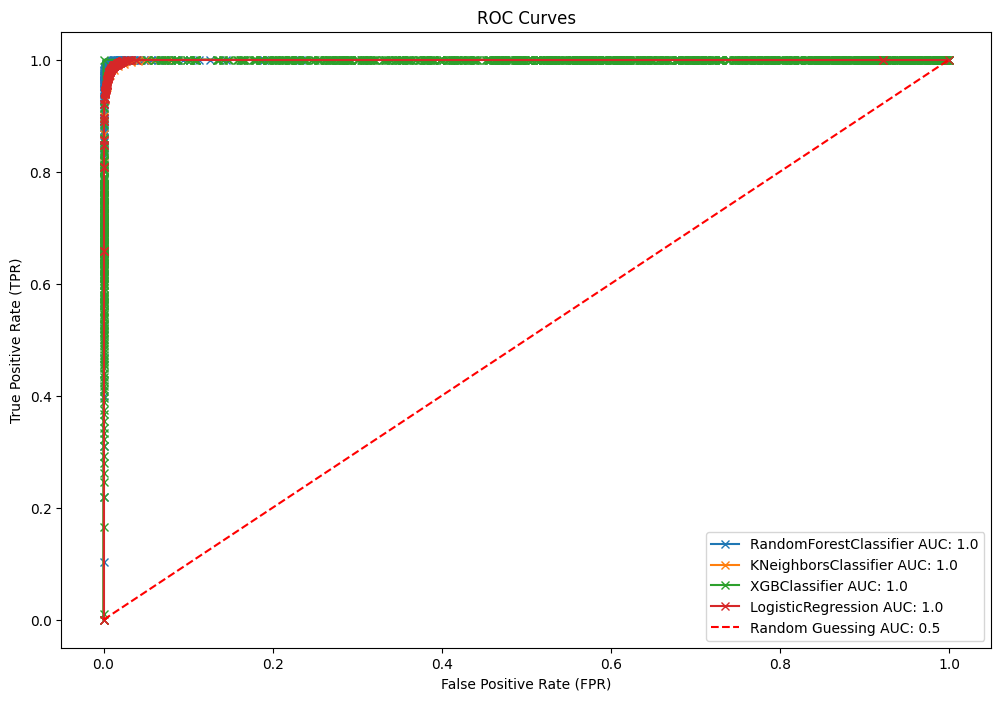

In [37]:
# Plot ROC Curves
fig,axs=plt.subplots(figsize=(12,8))
leg_list=[]
for model in list(roc_dict.keys()):
    plt.plot(roc_dict[model][0],roc_dict[model][1],'-x')
    mod_leg=model.__class__.__name__+' AUC: ' +str(round(roc_dict[model][2],2))
    leg_list.append(mod_leg)
plt.plot([0,1],[0,1],'--r')
leg_list.append('Random Guessing AUC: 0.5')
plt.legend(leg_list)
plt.title('ROC Curves')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

<span style="font-size:20px;"> We performed modeling using the following steps:</span>
<ol>
<li> We train a number of hyperparameter combinations for three classifiers: RandomForest, KNN and XGBoost. 
<li> For each model, we perform a grid search over the hyperparameter combinations and selec the model with the best overall validation score
<li> We then test this model by comparing the predicted data with the test data 
<li> looking at the classification metrics we can tell which model performed better
<li> The ROC curve is plotted that helps us evaluate the models at a glance
</ol>
<p><span style="font-size:20px;"> Advantages of this procedure:</span>
<ol><li> Allows us to quickly tune between a range of models with hyperparameters
<li> Grid search CV does cross-validation which increases robustness of model
<li> Tabular and graphical representation of the model results
</ol>
</p>
<p><span style="font-size:20px;"> How valid is the model?</span>
<br> 
<li> All models evaluated give much better predictions than random guessing on the test set
<li> However XGBClassifier provided both the best training validation and testing scores for accuracy, precision, recall and AUC (if only marginally)
<br><p><b> Given the high metrics on the test data, we can be confident that XGB will perform reasonably well with new data </b></p?</br>
<p><span style="font-size:20px;"> Concerns: </span>
<br> 
<li> The model will be more predictive the longer a customer has stayed with the company, since there will be more data for the model to adjust to the customer's patterns. 
<li> Therefore we should only predict for users who have signed up only before a certain period of time from today 

## Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).


<li> The model will predict if a rider is expected to remain a customer in the long term
<li> If the model predicts retention for a rider, we can survey them to see what they like about the service
<li> If the model predicts non-retention, we can entice them with benefits (free rides, etc..) to try and make them long term customers
<li> In addition, we can solicit feedback from the non-retentive customers for improvements